In [124]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import gridsearchcv and lasso and kfold
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
# Use GBC to predict the outcome
from sklearn.ensemble import GradientBoostingClassifier

In [281]:
training = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_16879/3416410604.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  training = pd.read_csv("training.csv")
/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_16879/3416410604.py:2: DtypeWarning: Columns (28,139) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv")


In [282]:
all_data = training.append(test, ignore_index=True)

all_data['outcome'] = (all_data['metric_locked_percent_first_114_lockable_days_v1']>0.7).astype(int)
all_data = all_data.drop(columns=['finance_order_id','metric_locked_percent_first_114_lockable_days_v1'])
all_data['weekend'] = all_data['time_day_of_week_v1'].apply(lambda x: x in [5,6,7]).astype(int)
all_data.head(10)

/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_16879/929078636.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = training.append(test, ignore_index=True)


,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,outcome,weekend
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,1,1,1,0,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,1,1,1,0,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,2,2,2,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,2,3,2,1,0,1,0
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,3,3,3,2,0,0,0
5,1639671698,924.0,56.0,143.0,792.0,279.0,0.000000,0.000000,0.019231,0.010870,...,0,0,0,1,1,1,0,0,0,0
6,1639671710,579.0,15.0,65.0,801.0,280.0,0.100000,0.050000,0.000000,0.000000,...,0,0,0,1,2,2,1,0,0,0
7,1639672338,123.0,5.0,13.0,557.0,279.0,0.000000,0.000000,0.000000,0.125000,...,18,0,0,2,3,4,1,0,0,0
8,1639673380,453.0,11.0,51.0,908.0,279.0,0.250000,0.133333,0.076923,0.016949,...,0,0,0,1,1,2,0,0,1,0
9,1639673841,63.0,9.0,42.0,340.0,279.0,0.071429,0.000000,0.000000,0.045455,...,0,0,0,4,4,5,1,0,0,0


In [283]:
#Store outcome y y_test and y_train
y = all_data['outcome']
y_test = y.iloc[training.shape[0]:]
y_train = y.iloc[:training.shape[0]]

#Drop columns that have 90% missing values
listNAN = all_data.isna().sum()/all_data.shape[0]
listNAN = listNAN[listNAN>0.99]

all_data=all_data.drop(columns=listNAN.index)

all_data.shape


(50000, 965)

In [284]:
y_train.describe()

count    25000.000000
mean         0.181240
std          0.385225
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: outcome, dtype: float64

In [285]:
features=all_data.columns
#Remove 'outcome from features
features = features.drop('outcome')
print(features)

Index(['application_time', 'clerk_loan_count_total_v1',
       'clerk_loan_count_last_7_days_v1', 'clerk_loan_count_last_28_days_v1',
       'clerk_loan_days_since_first_v1', 'clerk_loan_days_since_last_v1',
       'clerk_fpd_1_last_7_mature_days_v1',
       'clerk_fpd_3_last_7_mature_days_v1',
       'clerk_fpd_7_last_14_mature_days_v1',
       'clerk_fpd_15_last_28_mature_days_v1',
       ...
       'credit_account_count_payment_frequency_monthly_mx_v1',
       'credit_account_count_payment_frequency_biweekly_mx_v1',
       'credit_account_count_payment_frequency_bimonthly_mx_v1',
       'credit_account_count_payment_frequency_annually_mx_v1',
       'credit_account_count_distinct_account_type_mx_v1',
       'credit_account_count_distinct_credit_type_mx_v1',
       'credit_account_count_distinct_creditor_mx_v1',
       'credit_account_count_distinct_warning_mx_v1',
       'credit_account_count_creditor_motorcyle_finance_company_mx_v1',
       'weekend'],
      dtype='object', length=

In [286]:
#split features into categorical and numerical
cat_features = all_data[features].select_dtypes(include=['object']).columns
num_features = all_data[features].select_dtypes(exclude=['object']).columns

In [287]:
all_data_cat = pd.get_dummies(all_data[cat_features], drop_first = True)

#drop the categorical features from the original dataset
all_data = all_data.drop(cat_features, axis = 1)

#concatenate the dummy variables with the original dataset
all_data_binned = pd.concat([all_data, all_data_cat], axis = 1)

#store only the categorical features in a list
all_data_cat.rename(columns={'merchant_state_v1_nuevo león':'merchant_state_v1_nuevoLeon'},inplace=True)
all_data_cat['merchant_state_v1_nuevoLeon'] = all_data_cat['merchant_state_v1_nuevoLeon'] + all_data_cat['merchant_state_v1_nuevo leon']
all_data_cat = all_data_cat.drop(columns=['merchant_state_v1_nuevo leon'])
cat_features = all_data_cat.columns

all_data_binned.rename(columns={'merchant_state_v1_nuevo león':'merchant_state_v1_nuevoLeon'},inplace=True)

#merge colums 'merchant_state_v1_nuevo leon' and 'merchant_state_v1_nuevoLeon'
all_data_binned['merchant_state_v1_nuevoLeon'] = all_data_binned['merchant_state_v1_nuevoLeon'] + all_data_binned['merchant_state_v1_nuevo leon']
all_data_binned = all_data_binned.drop(columns=['merchant_state_v1_nuevo leon'])

all_data_binned.head(10)


,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,user_region_mx_v1_region_2,user_region_mx_v1_region_3,user_region_mx_v1_region_4,user_region_mx_v1_region_5,user_region_mx_v1_region_6,user_region_mx_v1_region_7,user_region_mx_v1_region_8,user_region_mx_v1_region_9,user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True,credit_inquiry_days_since_last_at_most_1_mx_v1_True
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,0,0,0,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,1,0,0,0,0,1,0
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
5,1639671698,924.0,56.0,143.0,792.0,279.0,0.000000,0.000000,0.019231,0.010870,...,0,1,0,0,0,0,0,0,0,0
6,1639671710,579.0,15.0,65.0,801.0,280.0,0.100000,0.050000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
7,1639672338,123.0,5.0,13.0,557.0,279.0,0.000000,0.000000,0.000000,0.125000,...,0,0,1,0,0,0,0,0,0,0
8,1639673380,453.0,11.0,51.0,908.0,279.0,0.250000,0.133333,0.076923,0.016949,...,0,0,0,1,0,0,0,0,0,0
9,1639673841,63.0,9.0,42.0,340.0,279.0,0.071429,0.000000,0.000000,0.045455,...,0,0,1,0,0,0,0,0,0,0


In [288]:
all_data_binned.shape

features=list(set(cat_features).union(set(num_features)))
len(features)

1040

In [289]:
training_processed = all_data_binned.iloc[0:len(training),:]
test_processed = all_data_binned.iloc[len(training):len(all_data_binned),:]

In [290]:
print(all_data_binned.isna().sum().sort_values(ascending=False))
print(training_processed.isna().sum().sort_values(ascending=False))

credit_delinquent_days_max_max_creditor_convenience_store_last_24_months_mx_v1          49496
credit_delinquent_days_max_max_creditor_automotive_mx_v1                                49494
credit_account_opening_days_since_last_creditor_automotive_mx_v1                        49494
credit_account_opening_days_since_last_creditor_savings_and_credit_cooperative_mx_v1    49490
credit_delinquent_days_max_max_creditor_savings_and_credit_cooperative_mx_v1            49490
                                                                                        ...  
credit_inquiry_count_creditor_convenience_store_last_6_months_mx_v1                         0
credit_inquiry_count_creditor_convenience_store_last_1_months_mx_v1                         0
credit_inquiry_count_creditor_community_finance_society_mx_v1                               0
credit_inquiry_count_creditor_communications_mx_v1                                          0
credit_inquiry_days_since_last_at_most_1_mx_v1_True         

In [291]:
listNAN=training_processed.isna().sum().sort_values(ascending=False)

listNAN.to_csv("ListNANTraining.csv",index = False)


In [292]:
#separate training_processed and test_processed into training_processed_cat and training_processed_num
training_processed_cat = training_processed[cat_features]
training_processed_num = training_processed[num_features]

test_processed_cat = test_processed[cat_features]
test_processed_num = test_processed[num_features]

In [293]:
#impute missing values in training_processed with mean of the column for numerical features and mode for categorical features using SimpleImputer
from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

training_processed_num = imp_num.fit_transform(training_processed_num)
test_processed_num = imp_num.transform(test_processed_num)

training_processed_cat = imp_cat.fit_transform(training_processed_cat)
test_processed_cat = imp_cat.transform(test_processed_cat)

#convert training_processed_cat and test_processed_cat to dataframe
training_processed_cat = pd.DataFrame(training_processed_cat, columns=cat_features)
test_processed_cat = pd.DataFrame(test_processed_cat, columns=cat_features)

#convert training_processed_num and test_processed_num to dataframe
training_processed_num = pd.DataFrame(training_processed_num, columns=num_features)
test_processed_num = pd.DataFrame(test_processed_num, columns=num_features)

#concatenate training_processed_cat and training_processed_num
training_processed = pd.concat([training_processed_cat, training_processed_num], axis = 1)

#concatenate test_processed_cat and test_processed_num
test_processed = pd.concat([test_processed_cat, test_processed_num], axis = 1)


In [294]:
#concatenate training_processed and y_train
training_processed = pd.concat([training_processed, y_train], axis = 1)

training_processed.head(10)

,merchant_state_v1_bc,merchant_state_v1_bcs,merchant_state_v1_camp,merchant_state_v1_cdmx,merchant_state_v1_chih,merchant_state_v1_chis,merchant_state_v1_coah,merchant_state_v1_col,merchant_state_v1_dgo,merchant_state_v1_gro,...,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,weekend,outcome
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,1
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,0
5,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
6,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0
7,0,0,0,0,0,0,1,0,0,0,...,18.0,0.0,0.0,2.0,3.0,4.0,1.0,0.0,0.0,0
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1
9,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,4.0,4.0,5.0,1.0,0.0,0.0,0


In [295]:
#Generate mock_test and mock_train using trainig_processed
from sklearn.model_selection import train_test_split
mock_train, mock_test = train_test_split(training_processed, test_size=0.2, random_state=42)

**Lasso**

In [296]:
trainingPredictorsAsMatrix = np.asarray(mock_train.loc[:,features])
validationPredictorsAsMatrix = np.asarray(mock_test.loc[:,features])

In [297]:
def plot_cv_results(clf, lambdas, print_best = True):
    cv_Results = pd.DataFrame(columns=['Lambda','AUC','SE_AUC'])
    cv_Results['Lambda'] = lambdas
    cv_Results['AUC'] = clf.cv_results_['mean_test_score']
    cv_Results['SE_AUC'] = clf.cv_results_['std_test_score']
    
    if print_best:
        auc_max = np.round(np.max(clf.cv_results_['mean_test_score']),3)
        lambda_max = np.round(lambdas[np.argmax(clf.cv_results_['mean_test_score'])],2)
        print('Best AUC=',auc_max,'achieved at lambda=',lambda_max)

    plt.errorbar(data = cv_Results, x='Lambda', y='AUC', yerr='SE_AUC',
                 color='black',ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('AUC')
    plt.show()

In [370]:
# Separate Target Variable and Predictor Variables
TargetVariable=['outcome']
featuresLasso=features

X=training_processed.loc[:20000,features]
y=training_processed.loc[:20000,TargetVariable]

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X_train)

# Generating the standardized values of X and y
X_train=PredictorScalerFit.transform(X_train)
X_test=PredictorScalerFit.transform(X_test)


# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18000, 1040)
(18000, 1)
(2001, 1040)
(2001, 1)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Log reg + lasso at best lambda achieves validation set of AUC= 0.6184081673818764


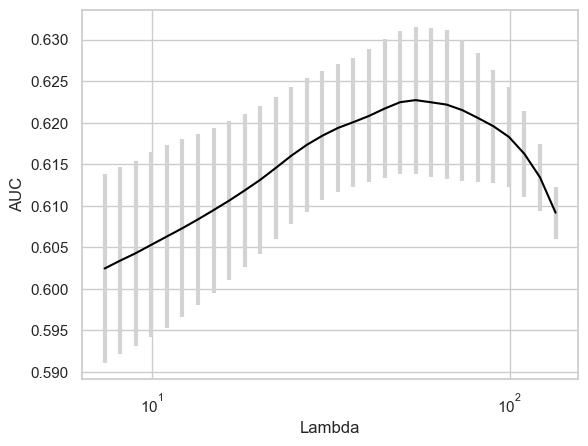

In [371]:
lambdas = np.exp(np.arange(2,5,0.1))
tuned_parameters = [{'C':1/lambdas,
                     'penalty':['l1'], 
                     'solver':['liblinear'],
                     'warm_start':[True]}]

model_lasso_cv = GridSearchCV(LogisticRegression(), tuned_parameters, scoring= 'roc_auc', 
                              cv = KFold(n_splits=5, random_state=None, shuffle=True), verbose=1, n_jobs=-1)

model_lasso_cv.fit(X_train, y_train.values.ravel())

valid_pred_lasso = model_lasso_cv.predict_proba(X_test)[:,1]

print('Log reg + lasso at best lambda achieves validation set of AUC=',roc_auc_score(y_test,valid_pred_lasso))

plot_cv_results(model_lasso_cv, lambdas, print_best= False)

In [372]:
features_names = list(features)
features_names.append('intercept')
all_coeff = np.append(model_lasso_cv.best_estimator_.coef_,model_lasso_cv.best_estimator_.intercept_)

coefficients_matrix = pd.DataFrame(data = {'Features': features_names, 'Coefficient':all_coeff})

nnz = np.sum(np.abs(all_coeff)>0)
print('Out of',len(features),'features,',nnz,'are selected by the Lasso.\n\n', coefficients_matrix.loc[np.abs(all_coeff)>0,:])

#get features selected by lasso without intercept
selectedLasso = list(coefficients_matrix.loc[np.abs(all_coeff)>0,'Features'])[:-1]

Out of 1040 features, 214 are selected by the Lasso.

                                                Features  Coefficient
4     credit_balance_total_creditor_collection_updat...     0.020035
7     credit_inquiry_count_creditor_self_financing_m...     0.008813
17               credit_inquiry_count_type_others_mx_v1    -0.005384
19    credit_account_count_warning_collateral_reposs...    -0.026554
25                               credit_limit_min_mx_v1    -0.006395
...                                                 ...          ...
1026       credit_account_count_type_payroll_loan_mx_v1     0.025898
1027  credit_account_opening_days_since_last_credito...    -0.006458
1030       credit_inquiry_count_distinct_creditor_mx_v1     0.103934
1037          credit_account_count_warning_sold_1_mx_v1    -0.003228
1040                                          intercept    -1.575379

[214 rows x 2 columns]


In [373]:
modelGBM = GradientBoostingClassifier(n_estimators=150) #n_estimators denotes the number of trees that are constructed
X=mock_train.loc[:,selectedLasso]
y=mock_train['outcome']
modelGBM.fit(X,y)

validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,selectedLasso])[:,1]
print('AUC of GBM model is',roc_auc_score(mock_test['outcome'], validationProbsGBM),'\n')

probsGBM=modelGBM.predict_proba(test_processed.loc[:,selectedLasso])[:,1]

print(probsGBM)

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsGBM
submission.to_csv("GBM.csv",index = False)
submission.head()

AUC of GBM model is 0.6540889495685864 

[0.13855057 0.16250041 0.1088742  ... 0.1917969  0.09260711 0.15986474]


,Id,Predicted
0,2025000,0.138551
1,2025001,0.162500
2,2025002,0.108874
3,2025003,0.093965
4,2025004,0.239312


In [170]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

clf = LinearSVC(C=0.01, penalty="l1", dual=False)
clf.fit(X_train, y_train.ravel())

rfe_selector = RFE(clf,n_features_to_select=300,verbose=1)
rfe_selector = rfe_selector.fit(X_train, y_train.ravel())

rfe_values = rfe_selector.get_support()


Fitting estimator with 350 features.
Fitting estimator with 349 features.
Fitting estimator with 348 features.
Fitting estimator with 347 features.
Fitting estimator with 346 features.
Fitting estimator with 345 features.
Fitting estimator with 344 features.
Fitting estimator with 343 features.
Fitting estimator with 342 features.
Fitting estimator with 341 features.
Fitting estimator with 340 features.
Fitting estimator with 339 features.
Fitting estimator with 338 features.
Fitting estimator with 337 features.
Fitting estimator with 336 features.
Fitting estimator with 335 features.
Fitting estimator with 334 features.
Fitting estimator with 333 features.
Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
F

In [171]:
rfe_indexes = np.where(rfe_values)[0]
rfe_features = mock_train.loc[:,features].columns[rfe_indexes]
print(rfe_features)

Index(['credit_delinquent_days_max_max_type_revolving_last_24_months_mx_v1',
       'credit_account_count_status_current_creditor_financial_leasing_companies_mx_v1',
       'credit_inquiry_count_creditor_communications_mx_v1',
       'credit_balance_total_delinquent_type_revolving_updated_last_6_months_mx_v1',
       'credit_account_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_days_since_last_type_personal_loan_mx_v1',
       'merchant_state_v1_bc',
       'credit_account_count_status_current_creditor_other_vehicles_mx_v1',
       'credit_delinquent_days_max_max_creditor_sofom_mx_v1',
       'credit_account_count_warning_deposit_forfeited_mx_v1',
       ...
       'credit_balance_total_delinquent_creditor_department_store_updated_last_6_months_mx_v1',
       'credit_account_count_warning_lawsuit_filed_mx_v1',
       'credit_inquiry_count_creditor_non_financial_leasing_companies_last_6_months_mx_v1',
       'credit_account_count_warning_identity_theft_mx_v1',
       'credi

In [378]:
X=training_processed.loc[:,selectedLasso]
y=training_processed[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X_train)

# Generating the standardized values of X and y
X_train=PredictorScalerFit.transform(X_train)
X_test=PredictorScalerFit.transform(X_test)


# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22500, 213)
(22500, 1)
(2500, 213)
(2500, 1)


In [369]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import regularizers
from keras import losses
from keras import metrics

classifier = Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
#classifier.add(Dense(units=20, input_dim=len(features), kernel_initializer='uniform', activation='relu'))

classifier.add(Dense(10, activation='relu', input_dim=len(selectedLasso) , kernel_initializer='uniform'))
classifier.add(Dense(5, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(1, activation='sigmoid'))

# Optimizer== the algorithm of SGG to keep updating weights
# loss== the loss function to measure the accuracy
# metrics== the way we will compare the accuracy after each step of SGD
from keras.optimizers import Adam
opt=Adam(learning_rate=0.001)
classifier.compile(optimizer=opt,
                    loss=losses.BinaryCrossentropy(from_logits=False),
                    metrics=[metrics.AUC(from_logits=False)])

# fitting the Neural Network on the training data
ANN_Model=classifier.fit(X_train,y_train, batch_size=64, epochs=30, verbose=1)

validationProbsANN  = classifier.predict(X_test)

pred_train= classifier.predict(X_train)
scores = classifier.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= classifier.predict(X_test)
scores2 = classifier.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1])) 

print('AUC of ANN model is',roc_auc_score(y_test, validationProbsANN),'\n')

X=test_processed.loc[:,selectedLasso]

### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

probsANN=classifier.predict(X)


submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsANN
submission.to_csv("benchmarkANN.csv",index = False)
submission.head()

Epoch 1/30


2023-02-22 21:20:07.475169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 6s 12ms/step - loss: 0.6449 - auc_48: 0.4974
Epoch 2/30
352/352 [==============================] - 3s 10ms/step - loss: 0.5716 - auc_48: 0.4986
Epoch 3/30
352/352 [==============================] - 3s 9ms/step - loss: 0.5263 - auc_48: 0.5030
Epoch 4/30
352/352 [==============================] - 3s 10ms/step - loss: 0.4980 - auc_48: 0.5568
Epoch 5/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4782 - auc_48: 0.5868
Epoch 6/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4647 - auc_48: 0.5949
Epoch 7/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4546 - auc_48: 0.6022
Epoch 8/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4477 - auc_48: 0.6172
Epoch 9/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4418 - auc_48: 0.6226
Epoch 10/30
352/352 [==============================] - 3s 9ms/step - loss: 0.4372 - auc_48: 0.6332
Epoch 11/30
352/352 [======

2023-02-22 21:21:47.768592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 1s 2ms/step


2023-02-22 21:21:49.481337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy on training data: 0.6762382984161377% 
 Error on training data: 0.3237617015838623
79/79 [==============================] - 0s 2ms/step
Accuracy on test data: 0.5530792474746704% 
 Error on test data: 0.4469207525253296
AUC of ANN model is 0.554144442753805 

782/782 [==============================] - 1s 2ms/step


,Id,Predicted
0,2025000,0.123343
1,2025001,0.123343
2,2025002,0.164021
3,2025003,0.123343
4,2025004,0.146419


In [374]:
#Implement random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

modelRF = RandomForestClassifier(n_estimators=300) #n_estimators denotes the number of trees that are constructed
X=mock_train.loc[:,selectedLasso]
y=mock_train['outcome']
modelRF.fit(X,y)

validationProbsRF  = modelRF.predict_proba(mock_test.loc[:,selectedLasso])[:,1]
print('AUC of RF model is',roc_auc_score(mock_test['outcome'], validationProbsRF),'\n')

probsRF=modelRF.predict_proba(test_processed.loc[:,selectedLasso])[:,1]

print(probsRF)

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsRF
submission.to_csv("RF.csv",index = False)
submission.head()


AUC of RF model is 0.6376366620785169 

[0.24666667 0.22       0.14666667 ... 0.26       0.18666667 0.35333333]


,Id,Predicted
0,2025000,0.246667
1,2025001,0.220000
2,2025002,0.146667
3,2025003,0.280000
4,2025004,0.260000


**XGBoost with hyperparameter tuning**

In [375]:
#XGBoost model
import xgboost as xgb
from sklearn.metrics import roc_auc_score

XGBtraining = xgb.DMatrix(mock_train.loc[:,selectedLasso], mock_train.loc[:,['outcome']])
XGBvalidation = xgb.DMatrix(mock_test.loc[:,selectedLasso], mock_test.loc[:,['outcome']])

XGBparam = {'max_depth':5, 'eta': 0.0690, 'objective': 'binary:logistic', 'min_child_weight': 1}
XGBparam['nthread'] = -1
XGBparam['eval_metric'] = 'auc'
XGBparam['seed'] = 0
XGBparam['colsample_bytree'] = 0.5
XGBparam['subsample']=0.5

evallist = [(XGBtraining, 'train'), (XGBvalidation, 'eval')]

num_round = 155 # This is the number of iterations (trees) that are constructed
modelXGB = xgb.train(XGBparam, XGBtraining,num_round)
validationProbsXGB = modelXGB.predict(XGBvalidation)

print('AUC of XGBoost model is',roc_auc_score(mock_test['outcome'], validationProbsXGB),'\n')

probsXGB=modelXGB.predict(xgb.DMatrix(test_processed.loc[:,selectedLasso]))

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsXGB
submission.to_csv("XGB_2.csv",index = False)
submission.head()


AUC of XGBoost model is 0.658112077242352 



,Id,Predicted
0,2025000,0.176397
1,2025001,0.171294
2,2025002,0.069830
3,2025003,0.243909
4,2025004,0.337576


In [379]:
#implement xgboost with hyperparameter tuning
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [4,5,6],
           'learning_rate': [0.0690, 0.0689, 0.0691],
           'n_estimators': [145, 150, 155]}

xgbr = XGBClassifier(objective= 'binary:logistic',
                    seed=42)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='roc_auc',
                   cv=5,
                   n_jobs=-1,
                   verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.0689, 'max_depth': 4, 'n_estimators': 155}
Best score: 0.6542946637566823


In [209]:
# Use scikit-learn to grid search the batch size and epochs
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from scikeras.wrappers import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
 # create model
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=len(rfe_features) , kernel_initializer='uniform', kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dense(5, activation='relu', kernel_initializer='uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.AUC(from_logits=False)])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# split into input (X) and output (Y) variables
X = training_processed.loc[:,rfe_features]
y = training_processed['outcome'].values

# create model
model = KerasClassifier(model=create_model, verbose=0)

# define the grid search parameters
batch_size = [60, 80, 100]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-22 14:50:21.489475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 14:50:21.489728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-22 14:50:21.503280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 14:50:21.503502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/10
Epoch 1/10


2023-02-22 14:50:22.438767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-22 14:50:22.442579: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-22 14:50:22.454426: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-22 14:50:22.466364: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10


2023-02-22 14:50:22.692166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.726107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.738163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.746580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.756316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.760173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 14:50:22.762233: I tensorflow/core/grappler/optimizers/cust

  1/209 [..............................] - ETA: 3s - loss: 30126.7852 - auc: 0.5000Epoch 2/10
Epoch 2/10
209/209 [==============================] - 7s 25ms/step - loss: 19872.5234 - auc: 0.4993
Epoch 2/10
278/278 [==============================] - 8s 24ms/step - loss: 2332.6675 - auc: 0.5083
Epoch 2/50
278/278 [==============================] - 8s 24ms/step - loss: 38646.0039 - auc: 0.4978
Epoch 2/10
278/278 [==============================] - 8s 25ms/step - loss: 10158.8359 - auc: 0.5019
Epoch 2/10
209/209 [==============================] - 5s 25ms/step - loss: 1650.6644 - auc: 0.4948
Epoch 3/10
209/209 [==============================] - 5s 25ms/step - loss: 16812.9688 - auc: 0.4992
Epoch 3/10
278/278 [==============================] - 7s 24ms/step - loss: 27156.6934 - auc: 0.5031
Epoch 3/50
209/209 [==============================] - 5s 25ms/step - loss: 9071.2598 - auc: 0.5022
Epoch 4/50
209/209 [==============================] - 5s 25ms/step - loss: 15989.3604 - auc: 0.5017
Epoch 4/1

KeyboardInterrupt: 